In [33]:
import torch
import torch.nn as nn
import torch.functional as f
import torch.optim as optim
from torch.autograd import Variable
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [46]:
class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        self.Enc = nn.Sequential(
            nn.Conv2d(1,16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.Dec = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3),
            nn.BatchNorm2d(1),
            nn.ReLU()
        )
    
    def forward(self, x):
        out = self.Enc(x)
        #out = out.view(batch_size, -1)
        out = out.view(batch_size, 32, 24, 24)
        out = self.Dec(out)
        return out

class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.Enc = nn.Sequential(
            # (28 - 3) / 1  + 1 = 26
            nn.Conv2d(1,16, 3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # (26 - 3) / 1 + 1 = 24
            nn.Conv2d(16,32,3),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 24 * 24, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        out = self.Enc(x)
        out = out.view(batch_size, 32*24*24)
        out = self.fc(out)
        return out

In [47]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 5

In [48]:
mnist_train = dset.FashionMNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.FashionMNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [49]:
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [51]:
generator = nn.DataParallel(G()).cuda()
discriminator = nn.DataParallel(D()).cuda()

gen_params = generator.state_dict().keys()
dis_params = discriminator.state_dict().keys()

In [52]:
loss_func = nn.MSELoss()
gen_optim = torch.optim.Adam(generator.parameters(), lr=learning_rate,betas=(0.5,0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate,betas=(0.5,0.999))

In [53]:
ones_label = Variable(torch.ones(batch_size,1)).cuda()
zeros_label = Variable(torch.zeros(batch_size,1)).cuda()

In [54]:
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        
        # Dis
        dis_optim.zero_grad()
        gen_fake = generator.forward(x)
        dis_fake = discriminator.forward(gen_fake)
        
        dis_real = discriminator.forward(x)
        dis_loss =  torch.sum(loss_func(dis_fake,zeros_label)) + torch.sum(loss_func(dis_real,ones_label))
        dis_loss.backward(retain_graph = True)
        dis_optim.step()
        
        # Gen
        gen_optim.zero_grad()
        gen_fake = generator.forward(x)
        dis_fake = discriminator.forward(gen_fake)
        
        gen_loss = torch.sum(loss_func(dis_fake, ones_label))
        gen_loss.backward()
        gen_optim.step()
        
        if j % 100 == 0:
            print(i)
            print(gen_loss,dis_loss)
            #torch.save([generator,discriminator],'./model/vanilla_gan.pkl')

            print("{}th iteration gen_loss: {} dis_loss: {}".format(i,gen_loss.data,dis_loss.data))
            #v_utils.save_image(gen_fake.data[0:25],"./result/gen_{}_{}.png".format(i,j), nrow=5)


0
tensor(0.2035, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.5036, device='cuda:0', grad_fn=<AddBackward0>)
0th iteration gen_loss: 0.20354342460632324 dis_loss: 0.503596305847168
0
tensor(0.6286, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3651, device='cuda:0', grad_fn=<AddBackward0>)
0th iteration gen_loss: 0.6286436319351196 dis_loss: 0.3650933802127838
0
tensor(0.4338, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3288, device='cuda:0', grad_fn=<AddBackward0>)
0th iteration gen_loss: 0.43382036685943604 dis_loss: 0.3287545442581177
1
tensor(0.5708, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3883, device='cuda:0', grad_fn=<AddBackward0>)
1th iteration gen_loss: 0.5707948207855225 dis_loss: 0.38826465606689453
1
tensor(0.4739, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4520, device='cuda:0', grad_fn=<AddBackward0>)
1th iteration gen_loss: 0.4739144444465637 dis_loss: 0.4520045816898346
1
tensor(0.2024, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4

In [12]:
gen_img = generator.forward(x)

In [13]:
import matplotlib.pyplot as plt

REAL


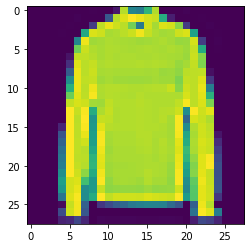

GAN


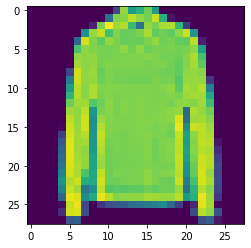

In [45]:
print("REAL")
plt.imshow(image[0][0])
plt.show()
print( "GAN")
plt.imshow(gen_img.detach().cpu()[0][0])
plt.show()